# 概要

ソフトマックス関数を出力層の活性化関数としてモデルを訓練した場合、出力層の直前のレイヤーから得られる出力は線形分離可能であるが(完全に分類可能である時のみ？)、それらの出力のうち、同じクラスに属するもので構成されるクラスターは分散が大きくなってしまうことがある。この分散を小さくするために"Center Loss"と呼ばれる新たな損失関数を導入して同時に最小化する。

In [44]:
import node
import numpy as np

In [56]:
class CenterLoss(node.Layer):
    
    def __init__(self, num_in_units, num_classes, alpha=0.01, gain=1.0):
        """
        引数
            num_classes: クラスターの数
            alpha: セントロイドの更新率
            gain: この関数の貢献度(大きいほどクラスターの分散が小さくなる)
        """
        
        self.num_in_units = num_in_units
        self.num_classes = num_classes
        self.alpha = alpha
        self.gain = gain
        
        # セントロイドを乱数で初期化する
        self.centroids = np.random.randn(num_classes, num_in_units)
        
    def __call__(self, input, target):
        # 各入力と対応するセントロイドとの誤差を計算する
        indeces = np.argmax(target.value, axis=1)
        error = input.mean_squared_error(node.Node(self.centroids[indeces]))
        
        # クラスターの更新量を求める
        delta = np.zeros([self.num_classes, self.num_in_units])
        np.add.at(delta, indeces, self.centroids[indeces]-input.value)
        
        # セントロイドを更新する
        counter = np.array([[np.count_nonzero(indeces==i)] for i in range(self.num_classes)])
        self.centroids -= self.alpha * (delta / (1 + counter))
        
        return self.gain * error

In [57]:
class Classifier(node.Network):
    
    def __init__(self, num_in_units, num_h_units, num_out_units):
        
        self.layers = [node.Linear(num_in_units, num_h_units),
                       node.Linear(num_h_units, 2),
                       node.Linear(2, num_out_units)]
        
        self.loss_function = CenterLoss(2, 10)
        
    def __call__(self, input, target):
        hidden = input
        hidden = self.layers[0](hidden).relu()
        hidden = self.layers[1](hidden)
        output = self.layers[2](hidden)
        loss = self.loss_function(hidden, target)
        
        return hidden, output, loss
    
classifier = Classifier(784, 256, 10)
optimizer = node.Adam(classifier.get_parameters(), 0.001)

In [58]:
def optimize(input, target):
    optimizer.zero_grad()
    
    # 普通の損失値とCenter Lossを計算する
    _, output, loss1 = classifier(input, target)
    loss2 = output.softmax_with_cross_entropy(target)
    loss = loss1 + loss2 
    
    # パラメーターを更新する
    loss.backward()
    optimizer()
    
    return loss.value

In [59]:
dataset = node.MNIST(training=True)
data_loader = node.DataLoader(dataset, batch_size=128)

In [61]:
import tqdm

for epoch in range(100):
    loss = 0
    for input, target in tqdm.tqdm_notebook(data_loader, leave=False):
        loss += optimize(input/255, target) / len(data_loader)
    print("epoch {0}, loss {1:.2f}".format(epoch, loss), flush=True)

epoch 0, loss 1.19
epoch 1, loss 1.88


KeyboardInterrupt: 

KeyboardInterrupt: 

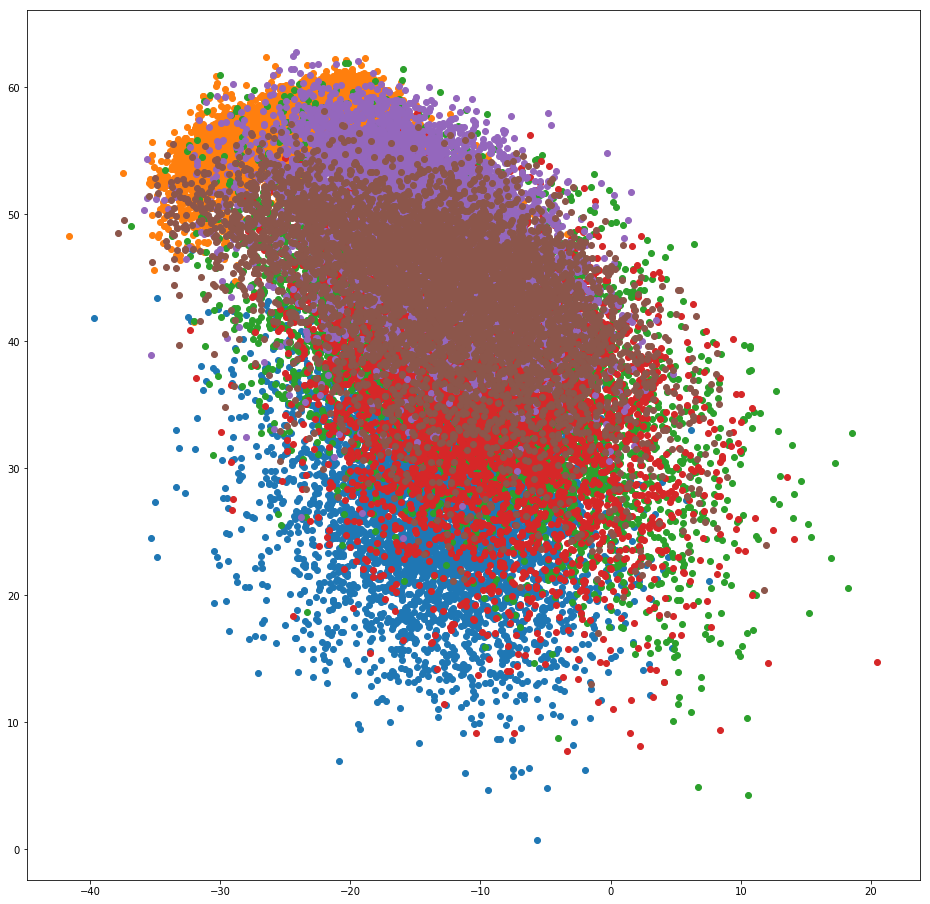

In [62]:
import matplotlib.pyplot as plt 
%matplotlib inline

distributions = [[] for _ in range(10)]

with node.zero_grad():
    for i in range(len(dataset)):
        input, target = dataset[i]
        hidden, _, _ = classifier(node.Node(input.reshape(1, -1)/255), 
                                  node.Node(target.reshape(1, -1)))
        distributions[np.argmax(target)].append(list(hidden.value[0]))

fig, ax = plt.subplots(figsize=[16, 16])
for i in range(10):
    ax.scatter(*zip(*distributions[i]))
ax.legend([str(i) for i in range(10)])
plt.show()